mamba create -n geo python=3.11 jupyterlab pandas numpy localtileserver ipyleaflet rasterio scipy geopandas shapely matplotlib rioxarray voila
mamba activate geo
# if on a mac
mamba install numpy "libblas=*=*accelerate"

In [2]:
from localtileserver import get_leaflet_tile_layer, TileClient
import rasterio
import pandas as pd
# from raster2xyz.raster2xyz import Raster2xyz
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.warp import transform
from rasterio.plot import show
from urllib import request
import glob
import rioxarray as rxr
from scipy.ndimage import gaussian_filter
import os
import json
import geopandas as gpd
from ipywidgets import widgets
from ipyleaflet import Map, GeoData, basemaps, LayersControl, \
ScaleControl, FullScreenControl, WidgetControl, SplitMapControl, Marker, LegendControl
from ipywidgets import widgets, IntSlider, jslink, Button, Layout
from IPython.display import display
from rasterio.io import MemoryFile
from pathlib import Path
from tqdm.auto import tqdm

In [ ]:
# Convert a tif to a csv with band values at x,y

input_raster = "organic_carbon_density.tif"
out_csv = "demo_out_xyz.csv"

rtxyz = Raster2xyz()
rtxyz.translate(input_raster, out_csv)

myRasterDF = pd.read_csv(out_csv)

In [3]:
def get_tif_corners(file_path):
    with rasterio.open(file_path) as src:
        # Get the bounds of the raster
        left, bottom, right, top = src.bounds

        # Get the CRS (Coordinate Reference System) of the raster
        src_crs = src.crs

        # Transform the corners from the source CRS to WGS84 (EPSG:4326)
        top_left_lon, top_left_lat = transform(src_crs, 'EPSG:4326', [left], [top])
        bottom_right_lon, bottom_right_lat = transform(src_crs, 'EPSG:4326', [right], [bottom])

        # Return the corners in WGS84
        return (top_left_lat[0], top_left_lon[0]), (bottom_right_lat[0], bottom_right_lon[0])

# Call the function
file_path = "delta.tif"
print(get_tif_corners(file_path))

((90.0, -180.0), (-90.0, 180.0))


In [4]:
def get_shapefile_bounds(file_path, region):
    # Load the shapefile
    gdf = gpd.read_file(file_path)

    # Filter the DataFrame for the specified region
    gdf = gdf[gdf['ADM1_ES'] == region]

    # Calculate the bounds for the region
    bounds = gdf.bounds

    # If you want to transform the bounds to WGS84 (EPSG:4326), you can do:
    gdf = gdf.to_crs('EPSG:4326')
    bounds = gdf.total_bounds
    minX, minY, maxX, maxY = bounds
    bounds_tuple = (minX, minY, maxX, maxY)

    # Return the bounds
    return bounds_tuple

# Call the function
file_path = "Ecuador shapefiles/ecu_admbnda_adm1_inec_20190724.shp"
region = "El Oro"
bounds = get_shapefile_bounds(file_path, region)

In [5]:
bounds.iloc[0]

minx   -80.439178
miny    -3.889949
maxx   -79.366473
maxy    -3.047489
Name: 6, dtype: float64

In [ ]:
with rasterio.open(file_path) as src:
    fig, ax = plt.subplots()
    
    # transform rasterio plot to real world coords
    extent = [bounds.iloc[0].minx, bounds.iloc[0].maxx, bounds.iloc[0].miny, bounds.iloc[0].maxy]
    ax = rasterio.plot.show(src, extent=extent, ax=ax, transform=src.transform, cmap='viridis')
    
    # gdf.plot(ax=ax)
    extent

In [ ]:
fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]

# Read the data with the window parameter
xmin, ymin, xmax, ymax = -80.8046, -4.4968, -78.80459999999998, -2.4968
window = src.window(xmin, ymin, xmax, ymax)
data = src.read(1, window=window)

# Exaggerate the colors with a logarithmic normalization
norm = plt.Normalize(vmin=data.min(), vmax=data.max())
log_norm = matplotlib.colors.LogNorm(vmin=data.min(), vmax=data.max())

# Show the plot with exaggerated colors
ax = show(data, ax=ax, norm=log_norm, cmap='viridis', extent=extent, transform=src.transform)

In [ ]:
src1 = rasterio.open("bana200a_yld.tif")
fig, ax = plt.subplots()
xmin, ymin, xmax, ymax = bounds.iloc[0].minx, bounds.iloc[0].miny, bounds.iloc[0].maxx, bounds.iloc[0].maxy #-80.8046, -4.4968, -78.80459999999998, -2.4968
window = src1.window(xmin, ymin, xmax, ymax)
data = src1.read(window=window)

# transform rasterio plot to real world coords
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = rasterio.plot.show(data, extent=extent, ax=ax, cmap="pink")

In [ ]:
src1 = rasterio.open("bana200a_yld1.tif")
fig, ax = plt.subplots()
xmin, ymin, xmax, ymax = -80.8046, -4.4968, -78.80459999999998, -2.4968
window = src1.window(xmin, ymin, xmax, ymax)
data = src1.read(window=window)

# transform rasterio plot to real world coords
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = rasterio.plot.show(data, extent=extent, ax=ax, transform=src1.transform, cmap='viridis')

In [ ]:
src1 = rasterio.open("banana_11-40-gfdl_esm2m_rcp45_irrigation_inputhigh.tif")
fig, ax = plt.subplots()
xmin, ymin, xmax, ymax = -80.8046, -4.4968, -78.80459999999998, -2.4968
window = src1.window(xmin, ymin, xmax, ymax)
data = src1.read(window=window)

# transform rasterio plot to real world coords
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = rasterio.plot.show(data, extent=extent, ax=ax, transform=src1.transform, cmap='viridis')

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def compute_and_plot_delta(file1, file2):
    xmin, ymin, xmax, ymax = -80.8046, -4.4968, -78.80459999999998, -2.4968
    # Load the two files
    with rasterio.open(file1) as src1:
        window = src1.window(xmin, ymin, xmax, ymax)
        band1 = src1.read(1, window=window)

    with rasterio.open(file2) as src2:
        window = src2.window(xmin, ymin, xmax, ymax)
        band2 = src2.read(1, window=window)

    # Compute the delta
    delta = band1 - band2
    print(type(delta))
    # Plot the delta
    plt.figure(figsize=(10, 10))
    plt.imshow(delta, cmap='RdBu')
    plt.colorbar(label='Delta')
    plt.title('Delta between RCP4.5 and 8.5')
    plt.show()

# Using the function
file1 = 'Potential Yield/potential_yield_gfdlesm2m_rcp2p6_2020_bana200a_yld.tif'
file2 = 'Potential Yield/potential_yield_gfdlesm2m_rcp8p5_2020_bana200a_yld.tif'

compute_and_plot_delta(file1, file2)


# Download tif files

In [ ]:
# actual yield
water = ["T", # total
         "R", # rainfed
         "I", # irrigated
        ]
time_periods = [ "2000", "2010"] 
variable = [ "yld", # yield
            "prd", # production
            "har", # harvested area]
            
# production
crops = ["ban", # banana
        "ricd", # dryland rice
        "lmze", # lowland maize
        "maiz", # maize 
        "ricw", # wetland rice
        "whea", # wheat
        "wwhe", # winter wheat]
url = f"https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res06/{water}/{time_periods}/{crops}_{time_periods}_{variable}.tif"

# crop value actual
crops = [ "all", # main
         "cer", # cereal
         "oil", # oil seeds
         "rts", # root crops
         

# value in (1000 GK$)
"https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res06/V/2000/all_2000_val.tif" # main
"https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res06/V/2000/cer_2000_val.tif" # cereal
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res06/V/2000/oil_2000_val.tif # oil seeds
            https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res06/V/2010/rts_2010_val.tif # root crops

# potential
2020: 2011-2040
2050: 2041-2070
2080: 2071-2100
         

# agro
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res02/GFDL-ESM2M/rcp8p5/2020sH/whea200a_yld.tif # irrigation 2011-2040
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res02/GFDL-ESM2M/rcp8p5/2020sH/whea200b_yld.tif # rain

In [3]:
rcps = [ "rcp2p6", "rcp8p5"]
years = [ "2020", "2050", "2080"]
crops = [
    # "bana", # banana
    #     "ricd", # dryland rice
    #     "lmze", # lowland maize
    #     "maiz", # maize 
    #     "ricw", # wetland rice
    #     "whea", # wheat
    #     "wwhe", # winter wheat
         # "soyb", #soybean
    "sugc"
        ]
waters = [ "a", # irrigation
         "b", # rain
         ]
for year in years:
    for rcp in rcps:
        for crop in crops:
            for water in waters:
                url = f"https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res02/GFDL-ESM2M/{rcp}/{year}sH/{crop}200{water}_yld.tif"
                filename = f"potential_yield_gfdlesm2m_{rcp}_{year}_{crop}200{water}_yld.tif"
                request.urlretrieve(url, filename)

In [ ]:
# Agro-climatic
# Thermal Regime
# Mean annual temp
# 2071-2100 -> 2080s
# 2011-2040 -> 2020s
# 2041-2070 -> 2050s
# Climate model ENSEMBLE
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/ENSEMBLE/rcp2p6/tmp_ENSEMBLE_rcp2p6_2080s.tif
# year 2080
# model GFDL-ESM2M
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/GFDL-ESM2M/rcp2p6/TS/tmp_GFDL-ESM2M_rcp2p6_2080.tif
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/GFDL-ESM2M/rcp8p5/TS/tmp_GFDL-ESM2M_rcp8p5_2092.tif
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/GFDL-ESM2M/rcp8p5/TS/tmp_GFDL-ESM2M_rcp8p5_2054.tif
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/GFDL-ESM2M/rcp8p5/tmp_GFDL-ESM2M_rcp8p5_2054.tif
# model HadGEM2-ES
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/HadGEM2-ES/rcp2p6/TS/tmp_HadGEM2-ES_rcp2p6_2080.tif
# model IPSL-CM5A-LR
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/IPSL-CM5A-LR/rcp2p6/TS/tmp_IPSL-CM5A-LR_rcp2p6_2080.tif
# MIROC-ESM-CHEM
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/MIROC-ESM-CHEM/rcp2p6/TS/tmp_MIROC-ESM-CHEM_rcp2p6_2080.tif
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/NorESM1-M/rcp2p6/TS/tmp_NorESM1-M_rcp2p6_2080.tif


# annual precipitation mm
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/NorESM1-M/rcp8p5/TS/prc_NorESM1-M_rcp8p5_2080.tif

# total number rain days
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/GFDL-ESM2M/rcp8p5/TS/ndr_GFDL-ESM2M_rcp8p5_2054.tif

In [10]:
rcps = [ "rcp2p6", "rcp8p5"]
years = [ "2020s", "2050s", "2080s"] + list(map(str, range(2011, 2100))) 
models = [ "ENSEMBLE", "GFDL-ESM2M" ] #"HadGEM2-ES",  ]

for year in tqdm(years):
    for rcp in tqdm(rcps):
        for model in tqdm(models):
            filename = f"Agroclimatic/Thermal regime/Mean annual temp/ts_tmp_{model}_{rcp}_{year}.tif"
            file = Path(filename)
            if not file.exists():
                url = f"https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/{model}/{rcp}/TS/tmp_{model}_{rcp}_{year}.tif"
                try:
                    request.urlretrieve(url, filename)
                except:
                    print("Could not fetch", url)

In [12]:
rcps = [ "rcp2p6", "rcp8p5"]
years = [ "2020s", "2050s", "2080s"] + list(map(str, range(2011, 2100))) 
models = [ "GFDL-ESM2M" ] #"HadGEM2-ES",  ]

for year in tqdm(years):
    for rcp in tqdm(rcps):
        for model in tqdm(models):
            filename = f"Agroclimatic/Moisture regime/Annual precipitation/prc_{model}_{rcp}_{year}.tif"
            file = Path(filename)
            if not file.exists():
                url = f"https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/{model}/{rcp}/TS/prc_{model}_{rcp}_{year}.tif"
                try:
                    request.urlretrieve(url, filename)
                except:
                    print("Could not fetch", url)

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Could not fetch https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/GFDL-ESM2M/rcp2p6/TS/prc_GFDL-ESM2M_rcp2p6_2020s.tif


  0%|          | 0/1 [00:00<?, ?it/s]

Could not fetch https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/GFDL-ESM2M/rcp8p5/TS/prc_GFDL-ESM2M_rcp8p5_2020s.tif


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Could not fetch https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/GFDL-ESM2M/rcp2p6/TS/prc_GFDL-ESM2M_rcp2p6_2050s.tif


  0%|          | 0/1 [00:00<?, ?it/s]

Could not fetch https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/GFDL-ESM2M/rcp8p5/TS/prc_GFDL-ESM2M_rcp8p5_2050s.tif


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Could not fetch https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/GFDL-ESM2M/rcp2p6/TS/prc_GFDL-ESM2M_rcp2p6_2080s.tif


  0%|          | 0/1 [00:00<?, ?it/s]

Could not fetch https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/GFDL-ESM2M/rcp8p5/TS/prc_GFDL-ESM2M_rcp8p5_2080s.tif


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
rcps = [ "rcp2p6", "rcp8p5"]
year_range = [ "2020s", "2050s", "2080s"]
models = [ "GFDL-ESM2M" ] #"HadGEM2-ES",  ]

for year in tqdm(year_range):
    for rcp in tqdm(rcps):
        for model in tqdm(models):
            filename = f"Agroclimatic/Moisture regime/Annual precipitation/prc_{model}_{rcp}_{year}.tif"
            file = Path(filename)
            if not file.exists():
                url = f"https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/{model}/{rcp}/prc_{model}_{rcp}_{year}.tif"
                try:
                    request.urlretrieve(url, filename)
                except:
                    print("Could not fetch", url)Agroclimatic/

In [ ]:
# Number of rain days
rcps = [ "rcp2p6", "rcp8p5"]
years = list(map(str, range(2011, 2100))) 
models = [ "GFDL-ESM2M" ] #"HadGEM2-ES",  ]
year_range = [ "2020s", "2050s", "2080s"]

for year in tqdm(year_range):
    for rcp in tqdm(rcps):
        for model in tqdm(models):
            filename = f"Agroclimatic/Moisture regime/Number of rain days/ndr_{model}_{rcp}_{year}.tif"
            file = Path(filename)
            if not file.exists():
                url = f"https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/{model}/{rcp}/ndr_{model}_{rcp}_{year}.tif"
                try:
                    request.urlretrieve(url, filename)
                except:
                    print("Could not fetch", url)
for year in tqdm(years):
    for rcp in tqdm(rcps):
        for model in tqdm(models):
            filename = f"Agroclimatic/Moisture regime/Number of rain days/ndr_{model}_{rcp}_{year}.tif"
            file = Path(filename)
            if not file.exists():
                url = f"https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/{model}/{rcp}/TS/ndr_{model}_{rcp}_{year}.tif"
                try:
                    request.urlretrieve(url, filename)
                except:
                    print("Could not fetch", url)

In [ ]:
import rasterio
from rasterio.warp import transform
import numpy as np
import pyproj

def get_pixel_value(lon, lat, raster_file):
    """
    Get pixel value of a GeoTIFF file at a specific lon/lat

    Parameters:
    lon (float): Longitude
    lat (float): Latitude
    raster_file (str): Path to raster file

    Returns:
    float: pixel value
    """

    # Open the raster file
    with rasterio.open(raster_file) as r:
        # Convert the lon/lat to the raster's coordinate system
        x, y = transform(
            pyproj.CRS('EPSG:4326'),  # Source coordinate system (WGS84)
            pyproj.Proj(r.crs),  # Destination coordinate system of the raster
            [lon], [lat]
        )

        # Get the pixel coordinates from the raster's geotransform
        x_pixel, y_pixel = rasterio.transform.rowcol(r.transform, x[0], y[0])

        # Read the data from the first band
        band1 = r.read(1)

        # Get the value at the pixel location
        return band1[x_pixel, y_pixel]

# Test the function
lon = -79.610968
lat = -3.371274 
raster_file = 'Agroclimatic/Moisture regime/Annual precipitation/prc_GFDL-ESM2M_rcp8p5_2069.tif'


# with rasterio.open(raster_file) as r:
#     print(r.crs)

print(get_pixel_value(lon, lat, raster_file))


In [23]:
from rasterio.windows import Window

In [5]:
def getCoordinatePixel(maps,lon,lat):
    # open map
    dataset = rasterio.open(maps)
    # get pixel x+y of the coordinate
    py, px = dataset.index(lon, lat)
    # print(py, px)
    # create 1x1px window of the pixel
    window = rasterio.windows.Window(px - 1//2, py - 1//2, 1, 1)
    # read rgb values of the window
    clip = dataset.read(window=window)
    return clip[0][0][0]#,clip[1][0][0],clip[2][0][0])

In [36]:
lon = -79.610968
lat = -3.371274 
getCoordinatePixel("Soil Grids/world_reference_soil_groups.tif", lon, lat)

6

In [52]:
print("Lat/long", lat, lon)
print("Annual precpitation (mm) 2069 RCP8.5:", 
      getCoordinatePixel("Agroclimatic/Moisture regime/Annual precipitation/prc_GFDL-ESM2M_rcp8p5_2069.tif", lon, lat))
print("Annual precpitation (mm) 2069 RCP2.6:", 
      getCoordinatePixel("Agroclimatic/Moisture regime/Annual precipitation/prc_GFDL-ESM2M_rcp2p6_2069.tif", lon, lat))
print()
print("Number rain days 2069 RCP8.5:", 
      getCoordinatePixel("Agroclimatic/Moisture regime/Number of rain days/ndr_GFDL-ESM2M_rcp8p5_2069.tif", lon, lat))
print("Number rain days 2069 RCP2.6:", 
      getCoordinatePixel("Agroclimatic/Moisture regime/Number of rain days/ndr_GFDL-ESM2M_rcp2p6_2069.tif", lon, lat))
print()
print("Mean annual temp (C) 2069 RCP8.5:", 
      getCoordinatePixel("Agroclimatic/Thermal regime/Mean annual temp/ts_tmp_GFDL-ESM2M_rcp8p5_2069.tif", lon, lat))
print("Mean annual temp (C) 2069 RCP2.6:", 
      getCoordinatePixel("Agroclimatic/Thermal regime/Mean annual temp/ts_tmp_GFDL-ESM2M_rcp2p6_2069.tif", lon, lat))
print()
print("Days Tmax > 35 2069 RCP8.5:", 
      getCoordinatePixel("Agroclimatic/Thermal regime/Tmax_gt_35/x35_GFDL-ESM2M_rcp8p5_2069.tif", lon, lat))
print("Days Tmax > 35 2069 RCP2.6:", 
      getCoordinatePixel("Agroclimatic/Thermal regime/Tmax_gt_35/x35_GFDL-ESM2M_rcp2p6_2069.tif", lon, lat))
print()
print("Days Tmin < 15 2069 RCP8.5:", 
      getCoordinatePixel("Agroclimatic/Thermal regime/Tmin_lt_15/n15_GFDL-ESM2M_rcp8p5_2069.tif", lon, lat))
print("Days Tmin < 15 2069 RCP2.6:", 
      getCoordinatePixel("Agroclimatic/Thermal regime/Tmin_lt_15/n15_GFDL-ESM2M_rcp2p6_2069.tif", lon, lat))

Lat/long -3.371274 -79.610968
Annual precpitation (mm) 2069 RCP8.5: 856
Annual precpitation (mm) 2069 RCP2.6: 1010

Number rain days 2069 RCP8.5: 196
Number rain days 2069 RCP2.6: 202

Mean annual temp (C) 2069 RCP8.5: 25.4
Mean annual temp (C) 2069 RCP2.6: 23.289999

Days Tmax > 35 2069 RCP8.5: 56
Days Tmax > 35 2069 RCP2.6: 23

Days Tmin < 15 2069 RCP8.5: 12
Days Tmin < 15 2069 RCP2.6: 123


In [11]:
lon = -80.1151
lat = -3.7957
years = list(map(str, range(2011, 2100)))
records = []
record = {"year": "", "rcp": "", "precipitation_mm": "", "rain_days":"","mean_temp": "", "tmax35": "", "tmin15":""}
for year in years:
    for rcp in rcps:
        record = {"year": year,
                  "rcp": rcp,
                  "precipitation_mm": getCoordinatePixel(f"Agroclimatic/Moisture regime/Annual precipitation/prc_GFDL-ESM2M_{rcp}_{year}.tif", lon, lat),
                  "rain_days": getCoordinatePixel(f"Agroclimatic/Moisture regime/Number of rain days/ndr_GFDL-ESM2M_{rcp}_{year}.tif", lon, lat),
                  "mean_temp": getCoordinatePixel(f"Agroclimatic/Thermal regime/Mean annual temp/ts_tmp_GFDL-ESM2M_{rcp}_{year}.tif", lon, lat),
                  "tmax35": getCoordinatePixel(f"Agroclimatic/Thermal regime/Tmax_gt_35/x35_GFDL-ESM2M_{rcp}_{year}.tif", lon, lat),
                  "tmin15": getCoordinatePixel(f"Agroclimatic/Thermal regime/Tmin_lt_15/n15_GFDL-ESM2M_{rcp}_{year}.tif", lon, lat)
                 }
        records.append(record)

In [14]:
df

,year,rcp,precipitation_mm,rain_days,mean_temp,tmax35,tmin15
0,2011,rcp2p6,750,150,25.400000,52,14
1,2011,rcp8p5,989,158,23.809999,2,47
2,2012,rcp2p6,834,136,24.010000,9,31
3,2012,rcp8p5,1013,160,23.910000,8,40
4,2013,rcp2p6,960,161,23.689999,9,46
...,...,...,...,...,...,...,...
173,2097,rcp8p5,865,155,27.939999,166,0
174,2098,rcp2p6,946,149,23.869999,3,53
175,2098,rcp8p5,1052,154,27.490000,152,0
176,2099,rcp2p6,841,147,25.400000,30,7


In [13]:
df = pd.DataFrame.from_records(records)

In [15]:
df.to_csv("hfdl-esm2m-3.7957_-80.1151.csv")

In [3]:
df = pd.read_csv("hfdl-esm2m-3.71_-79.61.csv")

rcp
rcp2p6    Axes(0.125,0.11;0.775x0.77)
rcp8p5    Axes(0.125,0.11;0.775x0.77)
Name: mean_temp, dtype: object

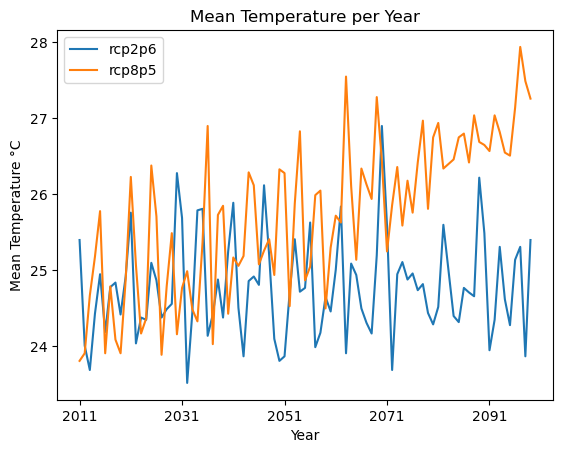

In [16]:
df[['year','rcp','mean_temp']].set_index("year").groupby("rcp")["mean_temp"].plot(legend=True, xlabel="Year", ylabel="Mean Temperature °C", title="Mean Temperature per Year")

rcp
rcp2p6    Axes(0.125,0.11;0.775x0.77)
rcp8p5    Axes(0.125,0.11;0.775x0.77)
Name: precipitation_mm, dtype: object

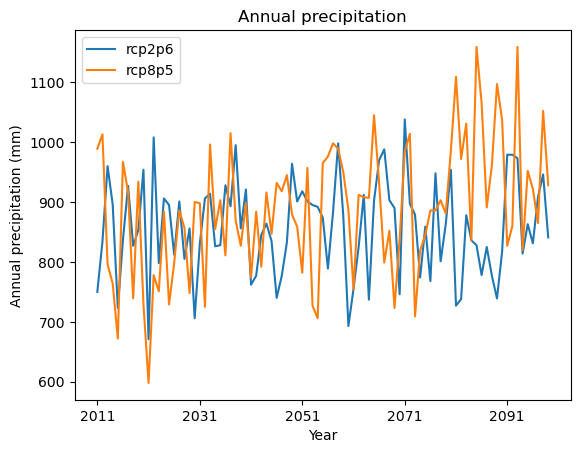

In [18]:
df[['year','rcp','precipitation_mm']].set_index("year").groupby("rcp")["precipitation_mm"].plot(legend=True, xlabel="Year", ylabel="Annual precipitation (mm)", title="Annual precipitation")

rcp
rcp2p6    Axes(0.125,0.11;0.775x0.77)
rcp8p5    Axes(0.125,0.11;0.775x0.77)
Name: rain_days, dtype: object

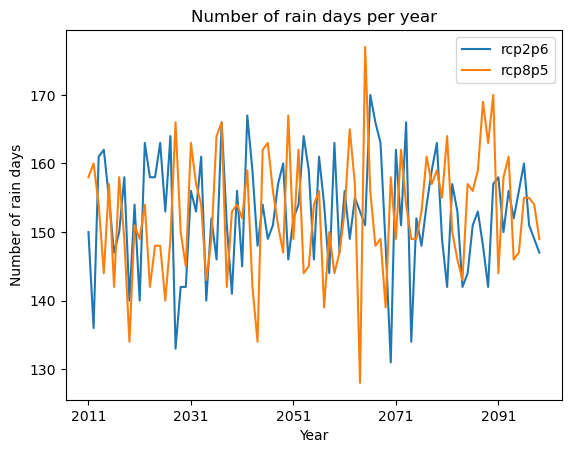

In [19]:
df[['year','rcp','rain_days']].set_index("year").groupby("rcp")["rain_days"].plot(legend=True, xlabel="Year", ylabel="Number of rain days", title="Number of rain days per year")

rcp
rcp2p6    Axes(0.125,0.11;0.775x0.77)
rcp8p5    Axes(0.125,0.11;0.775x0.77)
Name: tmax35, dtype: object

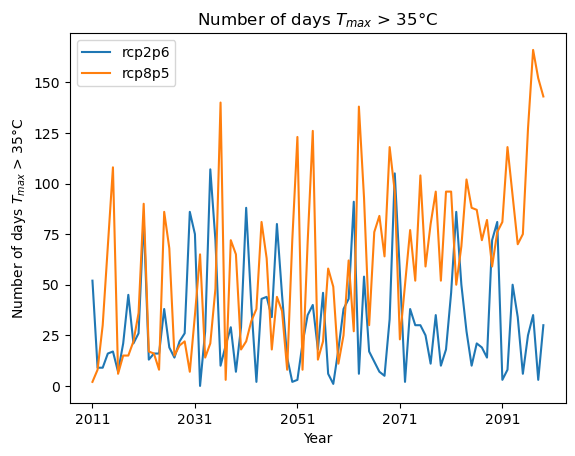

In [21]:
df[['year','rcp','tmax35']].set_index("year").groupby("rcp")["tmax35"].plot(legend=True, xlabel="Year", ylabel="Number of days $T_{max}$ > 35°C", title="Number of days $T_{max}$ > 35°C")

rcp
rcp2p6    Axes(0.125,0.11;0.775x0.77)
rcp8p5    Axes(0.125,0.11;0.775x0.77)
Name: tmin15, dtype: object

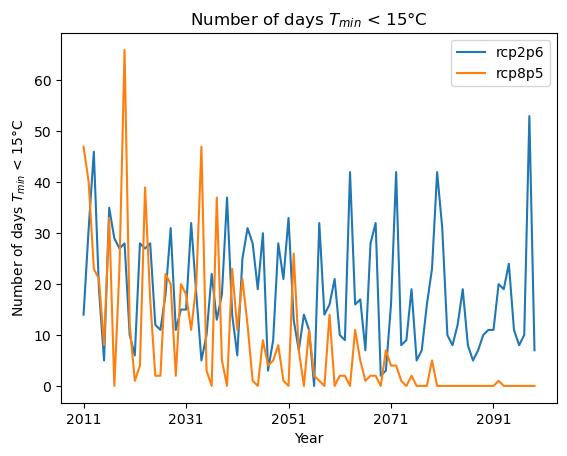

In [20]:
df[['year','rcp','tmin15']].set_index("year").groupby("rcp")["tmin15"].plot(legend=True, xlabel="Year", ylabel="Number of days $T_{min}$ < 15°C", title="Number of days $T_{min}$ < 15°C")

In [48]:
%%time
with rasterio.open(raster_file) as src:
        meta = src.meta

        # My target coordinates
        x_coord = lon
        y_coord = lat    
        # Use the transform in the metadata and your coordinates
        rowcol = rasterio.transform.rowcol(meta['transform'], xs=x_coord, ys=y_coord)
        print(rowcol)
        w = src.read(window=Window(rowcol[1], rowcol[0], 1, 1))
        # Do something with your data here.
        print(w)

(1120, 1204)
[[[856]]]
CPU times: user 4.47 ms, sys: 1.9 ms, total: 6.37 ms
Wall time: 5.09 ms


In [ ]:
# Tmax > 35 and Tmin < 15
rcps = [ "rcp2p6", "rcp8p5"]
years = list(map(str, range(2011, 2100))) 
models = [ "GFDL-ESM2M" ] #"HadGEM2-ES",  ]
year_range = [ "2020s", "2050s", "2080s"]

for year in tqdm(year_range):
    for rcp in tqdm(rcps):
        for model in tqdm(models):
            filename = f"Agroclimatic/Thermal regime/Tmin_lt_15/n15_{model}_{rcp}_{year}.tif"
            file = Path(filename)
            if not file.exists():
                url = f"https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/{model}/{rcp}/n15_{model}_{rcp}_{year}.tif"
                try:
                    request.urlretrieve(url, filename)
                except:
                    print("Could not fetch", url)
for year in tqdm(years):
    for rcp in tqdm(rcps):
        for model in tqdm(models):
            filename = f"Agroclimatic/Thermal regime/Tmin_lt_15/n15_{model}_{rcp}_{year}.tif"
            file = Path(filename)
            if not file.exists():
                url = f"https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/{model}/{rcp}/TS/n15_{model}_{rcp}_{year}.tif"
                try:
                    request.urlretrieve(url, filename)
                except:
                    print("Could not fetch", url)
for year in tqdm(year_range):
    for rcp in tqdm(rcps):
        for model in tqdm(models):
            filename = f"Agroclimatic/Thermal regime/Tmax_gt_35/x35_{model}_{rcp}_{year}.tif"
            file = Path(filename)
            if not file.exists():
                url = f"https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/{model}/{rcp}/x35_{model}_{rcp}_{year}.tif"
                try:
                    request.urlretrieve(url, filename)
                except:
                    print("Could not fetch", url)
for year in tqdm(years):
    for rcp in tqdm(rcps):
        for model in tqdm(models):
            filename = f"Agroclimatic/Thermal regime/Tmax_gt_35/x35_{model}_{rcp}_{year}.tif"
            file = Path(filename)
            if not file.exists():
                url = f"https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/{model}/{rcp}/TS/x35_{model}_{rcp}_{year}.tif"
                try:
                    request.urlretrieve(url, filename)
                except:
                    print("Could not fetch", url)

In [ ]:
# tmin < 15
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/GFDL-ESM2M/rcp8p5/n15_GFDL-ESM2M_rcp8p5_2050s.tif

# tmax > 35
https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res01/GFDL-ESM2M/rcp8p5/x35_GFDL-ESM2M_rcp8p5_2050s.tif

# List tif metadata

In [ ]:
# Get a list of all .tif files in the current directory
tif_files = glob.glob('*.tif')

# Apply the function to each file
for file in tif_files:
    raster = rxr.open_rasterio(file, 
                               masked=True)

    # print("The datatype of raster is:", type(raster))
    
    print(file, "The Coordinate Reference System (CRS) of your data is:", raster.rio.crs)
    # print("\nThe bounds of your data are:", raster.rio.bounds())
    # print("\nThe shape of your data is:", raster.shape)
    # print("\nThe spatial resolution for your data is:", raster.rio.resolution())
    # print("\nThe metadata for your data is:", raster.attrs)
    # print("\nThe nodatavalue of your data is:", raster.rio.nodata)

# Smooth tiff

In [2]:
def smooth_dataset(file_path, sigma):
    # Open the file
    with rasterio.open(file_path) as src:
        # Create an empty list to store the smoothed bands
        smoothed_bands = []

        # Apply the Gaussian filter to each band
        for band in src.read():
            smoothed_bands.append(gaussian_filter(band, sigma=sigma))

        # Create a new GeoTiff file
        path = Path(file_path)
        smoothed_file = path.parent / f"{path.stem}_smoothed{path.suffix}"
        with rasterio.open(smoothed_file, 'w', driver='GTiff', height=src.height,
                           width=src.width, count=src.count, dtype=src.dtypes[0],
                           crs=src.crs, transform=src.transform) as dst:
            # Write the smoothed bands to the new file
            for i, band in enumerate(smoothed_bands, start=1):
                dst.write(band, i)

    # Return a new DatasetReader for the new file
    return rasterio.open(smoothed_file)

# Compute delta

# Add shapefile layer

In [2]:
def addElOro(map_obj, selShp):
    selDf = gpd.read_file('Ecuador shapefiles/'+selShp+'.shp')
    selDf = selDf[selDf['ADM1_ES'] == "El Oro"]

    geoDf = selDf.to_crs(4326)
    lonCent = (geoDf.bounds.maxx + geoDf.bounds.minx).mean()/2
    latCent = (geoDf.bounds.maxy + geoDf.bounds.miny).mean()/2

    map_obj.center = (latCent,lonCent)
    geoData = GeoData(geo_dataframe=geoDf, name=selShp) #style={'color': 'black', 'fillColor': 'green', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   # hover_style={'fillColor': 'red' , 'fillOpacity': 0.2})
    map_obj.add_layer(geoData)
def showMap(selShp):
    addElOro(m, selShp)

# Map with slider

In [74]:
# Create tile servers from two raster files
raster1 = 'Potential Yield/potential_yield_gfdlesm2m_rcp2p6_2020_bana200a_yld.tif'
raster2 = 'Potential Yield/potential_yield_gfdlesm2m_rcp8p5_2080_bana200a_yld.tif'
l_client = TileClient(raster1)
r_client = TileClient(raster2)
max_zoom = 30
# Shared display parameters
display_dict = dict(vmin=0, vmax=150, cmap='viridis',
                    opacity=0.75, max_zoom=max_zoom,
    max_native_zoom=max_zoom,)

# Create 2 tile layers from different raster
l = get_leaflet_tile_layer(l_client, #palette='matplotlib.Viridis_20',
                           **display_dict)
r = get_leaflet_tile_layer(r_client, #palette='matplotlib.Plasma_6',
                           **display_dict)

# Make the ipyleaflet map
m = Map(center=(-3.371274, -79.610968),
        zoom=9, dragging=False)
control = SplitMapControl(left_layer=l, right_layer=r)
addElOro(m, "ecu_admbnda_adm2_inec_20190724")
m.add_control(ScaleControl(position='bottomleft'))
m.add_control(FullScreenControl())
m.add_control(control)

# Assuming 'm' is your ipyleaflet Map object
# m = ipyleaflet.Map(center=(-3.371274, -79.610968), zoom=10)

# Specify your latitude and longitude
lat, long = -3.371274, -79.610968

# Create a marker at the given latitude and longitude
marker = Marker(location=(lat, long))

# Add the marker to the map
m.add_layer(marker)
m

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

# Delta

In [5]:
with rasterio.open("Potential Yield/potential_yield_gfdlesm2m_rcp2p6_2020_bana200a_yld.tif") as src1:
    # window = src1.window(xmin, ymin, xmax, ymax)
    band1 = src1.read(1)#, window=window)

with rasterio.open("Potential Yield/potential_yield_gfdlesm2m_rcp8p5_2020_bana200a_yld.tif") as src2:
    # window = src2.window(xmin, ymin, xmax, ymax)
    band2 = src2.read(1)#, window=window)

# Compute the delta
delta = band1 - band2
new_file = "delta.tif"
with rasterio.open(new_file, 'w', driver='GTiff', height=delta.shape[0],
                   width=delta.shape[1], count=1, dtype=delta.dtype,
                   crs=src1.crs, transform=src1.transform) as dst:
    dst.write(delta, 1)

# Return a new DatasetReader for the new file
delta_fs = rasterio.open(new_file)


max_zoom = 30
delta_smooth = smooth_dataset(new_file, 5)
# First, create a tile server from local raster file
client = TileClient(delta_smooth)

# Create ipyleaflet tile layer from that server
t = get_leaflet_tile_layer(client, vmin=0, vmax=50, cmap='coolwarm', opacity=0.75, max_zoom=max_zoom,
    max_native_zoom=max_zoom)

m = Map(center=(-3.371274, -79.610968), zoom=9, layout=Layout(height='800px'), basemap=basemaps.OpenTopoMap)
addElOro(m, "ecu_admbnda_adm2_inec_20190724")
m.add_layer(t)
m

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [102]:
import ipywidgets as widgets
from IPython.display import display

# Create a list of years
years = [ "2011-2040 (2020)",  "2041-2070 (2050)", "2071-2100 (2080)"]
year_map = {
    "2071-2100 (2080)": "2080",
    "2011-2040 (2020)": "2020",
    "2041-2070 (2050)": "2050"
}
# Create a list of crops
crops = [ "Banana", "Rice", "Wheat", "Soybean"]
crop_map = {
    "Banana": "bana",
    "Rice": "ricw",
    "Wheat": "whea",
    "Soybean": "soyb"
}
# Create the widgets
year_widget = widgets.Dropdown(options = years, description='Select Year:')
crop_widget = widgets.Dropdown(options = crops, description='Select Crop:')



# Display the widgets
hbox = widgets.HBox([year_widget, crop_widget])

#map object
# m = Map(center=(-3.371274, -79.610968), zoom = 10, 
#         basemap = basemaps.OpenTopoMap)
m = Map(center=(-3.371274, -79.610968),
        zoom=8, dragging=False, basemap = basemaps.Esri.WorldImagery)
zoom_slider = IntSlider(description='Zoom level:', min=0, max=15, value=9)
jslink((zoom_slider, 'value'), (m, 'zoom'))
widgetControl = WidgetControl(widget=zoom_slider, position='topright')

max_zoom = 30
# Shared display parameters
display_dict = dict(
    #vmin=50, vmax=150,
    cmap='viridis', opacity=0.75, max_zoom=max_zoom,
    max_native_zoom=max_zoom,)

# Create 2 tile layers from different raster
l_client = TileClient('Potential Yield/potential_yield_gfdlesm2m_rcp2p6_2020_bana200a_yld.tif')
r_client = TileClient('Potential Yield/potential_yield_gfdlesm2m_rcp8p5_2020_bana200a_yld.tif')
left_layer_new = get_leaflet_tile_layer(l_client, **display_dict)
right_layer_new = get_leaflet_tile_layer(r_client, **display_dict)
control = SplitMapControl(left_layer=l, right_layer=r)
# Function to update map
def value_change(change):
    update_map(left_layer_new, right_layer_new, control, change)
def update_map(left_layer_new, right_layer_new, control, change):
    year = year_map[year_widget.value]
    crop = crop_map[crop_widget.value]
    # TODO: Implement your map update logic here
    # m.remove_control(control)
    for control in m.controls:
        if isinstance(control, SplitMapControl):
            m.remove_control(control)
    # m.remove_layer(left_layer_new)
    # m.remove_layer(right_layer_new)
    print("removed control")
    l_client = TileClient(f"Potential Yield/potential_yield_gfdlesm2m_rcp2p6_{year}_{crop}200a_yld.tif")
    r_client = TileClient(f"Potential Yield/potential_yield_gfdlesm2m_rcp8p5_{year}_{crop}200a_yld.tif")
    # Create new layers
    left_layer_new = get_leaflet_tile_layer(l_client, **display_dict)
    right_layer_new = get_leaflet_tile_layer(r_client, **display_dict)
    
    # Add a new SplitMapControl with the new layers
    control = SplitMapControl(left_layer=left_layer_new, right_layer=right_layer_new)
    l_pix = getCoordinatePixel(f"Potential Yield/potential_yield_gfdlesm2m_rcp2p6_{year}_{crop}200a_yld.tif", lon, lat)
    r_pix = getCoordinatePixel(f"Potential Yield/potential_yield_gfdlesm2m_rcp8p5_{year}_{crop}200a_yld.tif", lon, lat)
    marker = Marker(location=(lat, long), title=f"Yield: {l_pix} vs {r_pix} 1000T")

    # Add the marker to the map
    m.add_layer(marker)
    m.add_control(control)

# Set the function to be called on value change
year_widget.observe(value_change, names='value')
crop_widget.observe(value_change, names='value')

showMap("ecu_admbnda_adm2_inec_20190724")
m.add_control(widgetControl)
lat, long = -3.371274, -79.610968
    
# Create a marker at the given latitude and longitude

# m.add_layer(basemaps.OpenStreetMap.Mapnik)
m.add_control(ScaleControl(position='bottomleft'))
# m.add_control(FullScreenControl(position='topright'))
m.add_control(LayersControl())
m.add_control(FullScreenControl())

# m.add_control(control)
display(Markdown("## Crop yield RCP2.6 vs RCP8.5"))
display(hbox)
display(m)

## Crop yield RCP2.6 vs RCP8.5

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [96]:
m.layers

(TileLayer(attribution='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community', base=True, min_zoom=1, name='Esri.WorldImagery', options=['attribution', 'bounds', 'detect_retina', 'max_native_zoom', 'max_zoom', 'min_native_zoom', 'min_zoom', 'no_wrap', 'tile_size', 'tms', 'zoom_offset'], url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'),
 GeoData(data={'type': 'FeatureCollection', 'features': [{'id': '8', 'type': 'Feature', 'properties': {'Shape_Leng': 1.59325187947, 'Shape_Area': 0.0656526003064, 'ADM2_ES': 'Arenillas', 'ADM2_PCODE': 'EC0702', 'ADM2_REF': None, 'ADM2ALT1ES': None, 'ADM2ALT2ES': None, 'ADM1_ES': 'El Oro', 'ADM1_PCODE': 'EC07', 'ADM0_EN': 'Ecuador', 'ADM0_ES': 'Ecuador (el)', 'ADM0_PCODE': 'EC', 'date': '2018-12-17', 'validOn': '2019-07-24', 'validTo': None}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-80.03930257199994, -3.39

In [97]:
m.controls

(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text', 'zoom_out_title']),
 AttributionControl(options=['position', 'prefix'], position='bottomright'),
 WidgetControl(options=['position', 'transparent_bg'], position='topright', widget=IntSlider(value=9, description='Zoom level:', max=15)),
 ScaleControl(options=['imperial', 'max_width', 'metric', 'position', 'update_when_idle'], position='bottomleft'),
 LayersControl(options=['position']),
 FullScreenControl(options=['position']),
 SplitMapControl(left_layer=BoundTileLayer(attribution="Raster file served by <a href='https://github.com/banesullivan/localtileserver' target='_blank'>localtileserver</a>.", bounds=((-89.9999, -180.0), (89.9999, 180.0)), max_native_zoom=30, max_zoom=30, opacity=0.75, options=['attribution', 'bounds', 'detect_retina', 'max_native_zoom', 'max_zoom', 'min_native_zoom', 'min_zoom', 'no_wrap', 'tile_size', 'tms', 'zoom_offset'], show_loading=True, url='http://127.0.0.1:50305/api/tiles

In [52]:
#get shapefile name list
shpList = [x[:-4] for x in os.listdir('Ecuador shapefiles/') if x[-3:]=='shp']

#dropdown widget
selDrop = widgets.Dropdown(
    options=shpList,
    value=shpList[0],
    description='Shapefile:',
    disabled=False,
)

display(selDrop)

#button widget
selBot = widgets.Button(
    description='Select shapefile',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Select shapefile',
    icon='check'
)

display(selBot)

#map object
# m = Map(center=(-3.371274, -79.610968), zoom = 10, 
#         basemap = basemaps.OpenTopoMap)
m = Map(center=(-3.371274, -79.610968),
        zoom=9, dragging=False, basemap = basemaps.Esri.WorldImagery)
zoom_slider = IntSlider(description='Zoom level:', min=0, max=15, value=10)
jslink((zoom_slider, 'value'), (m, 'zoom'))
widgetControl = WidgetControl(widget=zoom_slider, position='topright')
l_client = TileClient('Actual Yields and Production/T/2010/ban_2010_prd.tif')
r_client = TileClient('Actual Yields and Production/V/2010/all_2010_val.tif')
max_zoom = 30
# Shared display parameters
display_dict = dict(vmin=50, vmax=150, cmap='viridis', opacity=0.75, max_zoom=max_zoom,
    max_native_zoom=max_zoom,)

# Create 2 tile layers from different raster
l = get_leaflet_tile_layer(l_client, **display_dict)
r = get_leaflet_tile_layer(r_client, **display_dict)

# Make the ipyleaflet map

control = SplitMapControl(left_layer=l, right_layer=r)

# m.add_control(ScaleControl(position='bottomleft'))

#show map function


#on click function
def on_button_clicked(b):
    showMap(selDrop.value)
showMap("ecu_admbnda_adm2_inec_20190724")
m.add_control(widgetControl)

# m.add_layer(basemaps.OpenStreetMap.Mapnik)
m.add_control(ScaleControl(position='bottomleft'))
# m.add_control(FullScreenControl(position='topright'))
m.add_control(LayersControl())
m.add_control(FullScreenControl())

m.add_control(control)
display(m)



# selBot.on_click(on_button_clicked)

Dropdown(description='Shapefile:', options=('paisaje', 'ecu_admbnda_adm1_inec_20190724', 'ecu_admbnda_adm0_ine…

Button(button_style='success', description='Select shapefile', icon='check', style=ButtonStyle(), tooltip='Sel…

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [8]:
# production in 1000T
client = TileClient("Actual Yields and Production/T/2010/ban_2010_prd.tif")
max_zoom = 30
# Create ipyleaflet tile layer from that server
t = get_leaflet_tile_layer(client, #vmin=0, vmax=50, 
                           cmap='coolwarm', 
                           opacity=0.75, max_zoom=max_zoom,
    max_native_zoom=max_zoom)

m = Map(center=(-3.371274, -79.610968), zoom=9, layout=Layout(height='800px'), basemap=basemaps.OpenTopoMap)
addElOro(m, "ecu_admbnda_adm2_inec_20190724")
lat, long = -3.371274, -79.610968

# Create a marker at the given latitude and longitude
marker = Marker(location=(lat, long))

# Add the marker to the map
m.add_layer(marker)
m.add_layer(t)
m

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [26]:
for file in glob.glob("Soil Grids/*.tif"):
    print(Path(file).stem)

mean_organic_carbon_density_0_5
mean_soil_organic_carbon_0_5
mean_silt_0_5
mean_clay_content_0_5
mean_nitrogen_0_5
mean_course_fragments_0_5
mean_cation_exchange_capacity_0_5
mean_sand_0_5
mean_bulk_density_0_5
mean_organic_carbon_stock_0_30
world_reference_soil_groups
mean_ph_water_0_5


In [37]:
import matplotlib.pyplot as plt

# Get the colormap
cmap = plt.get_cmap('tab20')

# Normalize the value to between 0 and 1
value_normalized = 6/20

# Fetch the rgba value from the colormap
rgba = cmap(value_normalized)

# Convert the rgb values to hex
hex_value = '#%02x%02x%02x' % (int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255))

print(hex_value)


#d62728


In [41]:
file_name_mapping = {
    'mean_organic_carbon_density_0_5': 'Mean Organic Carbon Density (0-5cm, g/dm³)',
    'mean_soil_organic_carbon_0_5': 'Mean Soil Organic Carbon (0-5cm, dg/kg)',
    'mean_silt_0_5': 'Mean Silt (0-5cm, g/kg)',
    'mean_clay_content_0_5': 'Mean Clay Content (0-5cm, g/kg)',
    'mean_nitrogen_0_5': 'Mean Nitrogen (0-5cm, cg/kg)',
    'mean_course_fragments_0_5': 'Mean Course Fragments (0-5cm, cm³/dm³)',
    'mean_cation_exchange_capacity_0_5': 'Mean Cation Exchange Capacity (0-5cm, mmol(c)/kg)',
    'mean_sand_0_5': 'Mean Sand (0-5cm, g/kg)',
    'mean_bulk_density_0_5': 'Mean Bulk Density (0-5cm, cg/cm³)',
    'mean_organic_carbon_stock_0_30': 'Mean Organic Carbon Stock (0-30cm, tonnes/ha)',
    'world_reference_soil_groups': 'World Reference Soil Groups',
    'mean_ph_water_0_5': 'Mean pH Water (0-5cm, pH * 10)'
}

for file in glob.glob("Soil Grids/*.tif"):
    file_p = Path(file)
    # production in 1000T
    client = TileClient(file)
    max_zoom = 30
    # Create ipyleaflet tile layer from that server
    cmap = "coolwarm"
    if file_p.stem == "world_reference_soil_groups":
        cmap = "tab20"
        legend = LegendControl({
            "Cambisols": "Green",
            "Ferralsols": "#d62728",
            "Andosols": "Orange",
            "Fluvisols": "rgb(231,150,142)",
            "Gleysols": "rgb(118, 96, 146)",
        }, name="Legend", position="topright")

        # Add the legend to the map
        

    t = get_leaflet_tile_layer(client, #vmin=0, vmax=50, 
                               cmap=cmap, 
                               opacity=0.75, max_zoom=max_zoom,
        max_native_zoom=max_zoom)
    
    m = Map(center=(-3.371274, -79.610968), zoom=10, layout=Layout(height='800px'), basemap=basemaps.Esri.WorldImagery)
    addElOro(m, "ecu_admbnda_adm2_inec_20190724")
    lat, long = -3.371274, -79.610968
    
    # Create a marker at the given latitude and longitude
    marker = Marker(location=(lat, long))
    if file_p.stem == "world_reference_soil_groups":
        m.add_control(legend)
    # Add the marker to the map
    m.add_layer(marker)
    m.add_layer(t)
    
    display(Markdown(f"## {file_name_mapping[file_p.stem]}"))
    display(m)
    # break

## Mean Organic Carbon Density (0-5cm, g/dm³)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Soil Organic Carbon (0-5cm, dg/kg)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Silt (0-5cm, g/kg)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Clay Content (0-5cm, g/kg)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Nitrogen (0-5cm, cg/kg)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Course Fragments (0-5cm, cm³/dm³)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Cation Exchange Capacity (0-5cm, mmol(c)/kg)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Sand (0-5cm, g/kg)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Bulk Density (0-5cm, cg/cm³)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Organic Carbon Stock (0-30cm, tonnes/ha)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## World Reference Soil Groups

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean pH Water (0-5cm, pH * 10)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [41]:
file_name_mapping = {
    'mean_organic_carbon_density_0_5': 'Mean Organic Carbon Density (0-5cm, g/dm³)',
    'mean_soil_organic_carbon_0_5': 'Mean Soil Organic Carbon (0-5cm, dg/kg)',
    'mean_silt_0_5': 'Mean Silt (0-5cm, g/kg)',
    'mean_clay_content_0_5': 'Mean Clay Content (0-5cm, g/kg)',
    'mean_nitrogen_0_5': 'Mean Nitrogen (0-5cm, cg/kg)',
    'mean_course_fragments_0_5': 'Mean Course Fragments (0-5cm, cm³/dm³)',
    'mean_cation_exchange_capacity_0_5': 'Mean Cation Exchange Capacity (0-5cm, mmol(c)/kg)',
    'mean_sand_0_5': 'Mean Sand (0-5cm, g/kg)',
    'mean_bulk_density_0_5': 'Mean Bulk Density (0-5cm, cg/cm³)',
    'mean_organic_carbon_stock_0_30': 'Mean Organic Carbon Stock (0-30cm, tonnes/ha)',
    'world_reference_soil_groups': 'World Reference Soil Groups',
    'mean_ph_water_0_5': 'Mean pH Water (0-5cm, pH * 10)'
}

for file in glob.glob("Soil Grids/*.tif"):
    file_p = Path(file)
    # production in 1000T
    client = TileClient(file)
    max_zoom = 30
    # Create ipyleaflet tile layer from that server
    cmap = "coolwarm"
    if file_p.stem == "world_reference_soil_groups":
        cmap = "tab20"
        legend = LegendControl({
            "Cambisols": "Green",
            "Ferralsols": "#d62728",
            "Andosols": "Orange",
            "Fluvisols": "rgb(231,150,142)",
            "Gleysols": "rgb(118, 96, 146)",
        }, name="Legend", position="topright")

        # Add the legend to the map
        

    t = get_leaflet_tile_layer(client, #vmin=0, vmax=50, 
                               cmap=cmap, 
                               opacity=0.75, max_zoom=max_zoom,
        max_native_zoom=max_zoom)
    
    m = Map(center=(-3.371274, -79.610968), zoom=10, layout=Layout(height='800px'), basemap=basemaps.Esri.WorldImagery)
    addElOro(m, "ecu_admbnda_adm2_inec_20190724")
    lat, long = -3.371274, -79.610968
    
    # Create a marker at the given latitude and longitude
    marker = Marker(location=(lat, long))
    if file_p.stem == "world_reference_soil_groups":
        m.add_control(legend)
    # Add the marker to the map
    m.add_layer(marker)
    m.add_layer(t)
    
    display(Markdown(f"## {file_name_mapping[file_p.stem]}"))
    display(m)
    # break

## Mean Organic Carbon Density (0-5cm, g/dm³)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Soil Organic Carbon (0-5cm, dg/kg)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Silt (0-5cm, g/kg)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Clay Content (0-5cm, g/kg)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Nitrogen (0-5cm, cg/kg)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Course Fragments (0-5cm, cm³/dm³)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Cation Exchange Capacity (0-5cm, mmol(c)/kg)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Sand (0-5cm, g/kg)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Bulk Density (0-5cm, cg/cm³)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean Organic Carbon Stock (0-30cm, tonnes/ha)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## World Reference Soil Groups

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Mean pH Water (0-5cm, pH * 10)

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [106]:
# production in 1000T
client = TileClient("Actual Yields and Production/T/2010/ban_2010_prd.tif")

# Create ipyleaflet tile layer from that server
t = get_leaflet_tile_layer(client, #vmin=0, vmax=50,
                           cmap='viridis', 
                           opacity=0.75, max_zoom=max_zoom,
    max_native_zoom=max_zoom)

m = Map(center=(-3.371274, -79.610968), zoom=9, layout=Layout(height='800px'), basemap=basemaps.Esri.WorldImagery)
addElOro(m, "ecu_admbnda_adm2_inec_20190724")
lat, long = -3.371274, -79.610968
yieldd = getCoordinatePixel("Actual Yields and Production/T/2010/ban_2010_prd.tif", long, lat)
# Create a marker at the given latitude and longitude
marker = Marker(location=(lat, long), title=f"Yield {yieldd:.2f} 1000T")

# Add the marker to the map
m.add_layer(marker)
m.add_layer(t)
display(Markdown("## Actual Yield 2010"))
display(m)

## Actual Yield 2010

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

# Soil map

In [13]:
client = TileClient("Land and Water Resources/aez/aez_v9v2_CRUTS32_Hist_8110_100_avg.tif")

# Create ipyleaflet tile layer from that server
t = get_leaflet_tile_layer(client, #vmin=0, vmax=50, cmap='coolwarm', 
                           opacity=0.75, max_zoom=max_zoom,
    max_native_zoom=max_zoom)

m = Map(center=(-3.371274, -79.610968), zoom=9, layout=Layout(height='800px'), basemap=basemaps.Esri.WorldImagery)
addElOro(m, "ecu_admbnda_adm2_inec_20190724")
lat, long = -3.371274, -79.610968

# Create a marker at the given latitude and longitude
marker = Marker(location=(lat, long))

# Add the marker to the map
m.add_layer(marker)
m.add_layer(t)
m

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [14]:
client = TileClient("Soil Grids/world_reference_soil_groups.tif")

# Create ipyleaflet tile layer from that server
t = get_leaflet_tile_layer(client, #vmin=0, vmax=50, 
                           cmap='tab20', 
                           opacity=0.75, max_zoom=max_zoom,
    max_native_zoom=max_zoom)

m = Map(center=(-3.371274, -79.610968), zoom=9, layout=Layout(height='800px'), basemap=basemaps.Esri.WorldImagery)
addElOro(m, "ecu_admbnda_adm2_inec_20190724")
m.add_layer(t)
m

Map(center=[-3.538806962642807, -79.84343566192852], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [ ]:
faostat = pd.read_csv("./Production Data/FAOSTAT_data_en_5-10-2023.csv")

In [ ]:
espac = pd.read_csv("./Production Data/PARTICIPACION_ESPAC_data.utf8.csv", delimiter='\t')

In [ ]:
productos = pd.read_csv("./Production Data/PRINCIPALES_PRODUCTOS1_data (1).utf8.csv", delimiter='\t')

In [ ]:
productos1 = pd.read_csv("./Production Data/PRINCIPALES_PRODUCTOS1_data.utf8.csv", delimiter='\t')

In [ ]:
rend = pd.read_csv("./Production Data/PROD_REND_ESPAC_data.utf8.csv", delimiter='\t')

In [ ]:
espac1 = pd.read_csv("./Production Data/SPC_ESPAC1_data.utf8.csv", delimiter='\t')

In [ ]:
variables = pd.read_csv("./Production Data/VARIABLES_data.utf8.csv", delimiter='\t')

In [ ]:
faostat[faostat.Area == "Ecuador"].head(5)

In [ ]:
espac

In [ ]:
productos.head(5)

In [ ]:
rend.head(5)

In [ ]:
espac1.head(5)

In [ ]:
variables

# Land and Water Resources
# aez - Agro-ecological zones
  # AEZ classification
    Dominant AEZ
    Moisture regime
    Simplified AEZ
    Soil/terrain and special purpose
    Thermal regime
# Exclusion areas
# Land Cover
# Socio-econmic data
# Soil resources
# Soil suitability
# Terrain Resources
# Water resources

# Agroclimatic
# Growing Period
# Climate classification
# Moisture Regime
# Thermal regime